# Data Processing with `geoPFA`: 2D Example from Newberry Volcano, OR
This tutorial demonstrates how to use the **data processing workflow** in `geoPFA`.  
You’ll learn how to:

1. Load a PFA configuration file (which defines criteria, components, and layers)
2. Read raw geospatial datasets into the working `pfa` dictionary
3. Process and clean these datasets into a consistent grid ready for layer combination and favorability modeling

Subsequent notebooks will build upon this by combining layers, applying weights, and producing final favorability models.

## 1. Imports and Setup

In [20]:
# --- General imports ---
from pathlib import Path
import geopandas as gpd

# --- geoPFA core classes ---
from geoPFA.data_readers import GeospatialDataReaders
from geoPFA.geopfa2d.processing import Cleaners, Processing  # TODO: change to geoPFA.processing
from geoPFA.geopfa2d.plotters import GeospatialDataPlotters  # TODO: change to geoPFA.plotters

# --- Utilities ---
from rex.utilities.utilities import safe_json_load

### Define Project Paths

In [21]:
# Get the directory where this notebook lives
notebook_dir = Path(__file__).resolve().parent if "__file__" in locals() else Path.cwd()

# Define the main project directory (where 'config/', 'data/', and 'notebooks/' live)
project_dir = notebook_dir.parent

# Define subdirectories
config_dir = project_dir / "config"
data_dir = project_dir / "data"

# Confirm structure
print("Notebook directory:", notebook_dir)
print("Config directory:", config_dir)
print("Data directory:", data_dir)

# Quick check before proceeding
for folder in [config_dir, data_dir]:
    if not folder.exists():
        raise FileNotFoundError(f"Expected folder not found: {folder}")

Notebook directory: c:\Users\smello\Documents\geoPFA\examples\Newberry\2D\notebooks
Config directory: c:\Users\smello\Documents\geoPFA\examples\Newberry\2D\config
Data directory: c:\Users\smello\Documents\geoPFA\examples\Newberry\2D\data


## 2. Reading Input Data
With the project directories defined, the next step is to **read the configuration file** and **load all raw geospatial data** into memory.

Each PFA project is organized according to a hierarchy of criteria → components → layers, where each **layer** represents a dataset.  

The configuration JSON defines:
- Which layers belong to which components and criteria  
- File names, coordinate reference systems (CRS), and column definitions  
- Processing instructions (e.g., interpolation methods)

To ensure a smooth workflow:
- Folder names and file names under `/data` must exactly match those specified in the JSON.  
- Each dataset must have consistent column names and units with its config entry.  

### Read configuration file

In [22]:
# Path to configuration file
pfa_path = config_dir / "newberry_superhot_config.json"

# Load JSON configuration safely (handles comments and malformed JSON)
pfa = safe_json_load(str(pfa_path))

# Quick check
if not pfa_path.exists():
    raise FileNotFoundError(f"Configuration file not found: {pfa_path}")

pfa = safe_json_load(str(pfa_path))
print(f"Loaded PFA configuration from: {pfa_path}")

Loaded PFA configuration from: c:\Users\smello\Documents\geoPFA\examples\Newberry\2D\config\newberry_superhot_config.json


### Load data into the `pfa` dictionary

In [23]:
# Define the file types to be read (others will be skipped with a warning)
file_types = [".csv", ".shp"]

# Gather data according to the config structure
pfa = GeospatialDataReaders.gather_data(data_dir, pfa, file_types)

criteria: geologic
	 component: heat
		 reading layer: density_joint_inv
		 reading layer: mt_resistivity_joint_inv
		 reading layer: temperature_model_500m
		 reading layer: velocity_model_vp
		 reading layer: velocity_model_vs
		 reading layer: velocity_model_vpvs
		 reading layer: earthquakes
	 component: producibility
		 reading layer: faults_newberry
		 reading layer: density_joint_inv
		 reading layer: mt_resistivity_joint_inv
		 reading layer: velocity_model_vp
		 reading layer: velocity_model_vs
		 reading layer: velocity_model_vpvs
		 reading layer: earthquakes
	 component: insulation
		 reading layer: density_joint_inv
		 reading layer: mt_resistivity_joint_inv
		 reading layer: velocity_model_vp
		 reading layer: earthquakes


### Verify that all layers loaded correctly
This simple diagnostic ensures that each layer entry in the `pfa` dictionary contains a `"data"` key with a valid GeoDataFrame.

In [24]:
missing_data_layers = []

for criteria, crit_data in pfa.get("criteria", {}).items():
    for component, comp_data in crit_data.get("components", {}).items():
        for layer, layer_data in comp_data.get("layers", {}).items():
            if "data" not in layer_data:
                missing_data_layers.append({
                    "criteria": criteria,
                    "component": component,
                    "layer": layer,
                })

if missing_data_layers:
    print("Layers missing 'data':")
    for item in missing_data_layers:
        print(f" - {item['criteria']} / {item['component']} / {item['layer']}")
else:
    print("All layers contain 'data'.")

All layers contain 'data'.


## 3. Harmonizing Coordinate Systems, Elevations, and Extents

Now that all raw layers are loaded into the `pfa` dictionary, we’ll:
- Define a target coordinate reference system (CRS)
- Derive a shared spatial extent for clipping and gridding
- Preview the input data layers

### Define the Target CRS and Project Boundary

In [25]:
# EPSG code for UTM Zone 10N (meters)
target_crs = 26910

# Load the project boundary shapefile
outline_path = data_dir / "supporting_data" / "national_monument_boundary" / "NNVM_bounds.shp"
outline = gpd.read_file(outline_path).to_crs(target_crs)

print(f"Loaded boundary: {outline_path.name}")

Loaded boundary: NNVM_bounds.shp


### Unify CRS and Define Extent

In [26]:
# Reproject all layers to the target CRS
pfa = Cleaners.set_crs(pfa, target_crs=target_crs)

# Choose one representative layer to define the spatial extent
extent_layer = (
    pfa["criteria"]["geologic"]["components"]["heat"]["layers"]["mt_resistivity_joint_inv"]["data"]
)
extent = Cleaners.get_extent(extent_layer)

# Validate the extent
print(f"Extent: {extent}")
if extent[0] >= extent[2] or extent[1] >= extent[3]:
    raise ValueError("Invalid extent: min values must be less than max values.")

# Define the active criterion (geologic only in this example)
criteria = "geologic"

Extent: [np.float64(624790.891073), np.float64(4825350.71118), np.float64(653145.891073), np.float64(4855310.71118)]


## 4. Convert 3D Layers to 2D

Many datasets in a PFA project are generated or modeled in 3D, but 2D PFAs
often only require a surface representation.  
This step uses `Processing.convert_3d_to_2d()` to **collapse each 3D layer along the Z-dimension**
into a 2D `GeoDataFrame`.

Layers are only flattened if:
- They are marked as `"is_3d": "yes"` in the configuration file  
- They are **not** explicitly excluded (`"needs_flattening": "no"`)

To save time, each unique layer is flattened **only once** and then reused for any other component that references it.
This is especially useful for large shared datasets.


In [27]:
# Cache to store flattened layers and reuse them
flattened_layers = {}

for component, comp_data in pfa["criteria"][criteria]["components"].items():
    for layer, layer_config in comp_data["layers"].items():
        is_3d = layer_config.get("is_3d", None)
        needs_flattening = layer_config.get("needs_flattening", "yes")

        # Skip layers not flagged as 3D or marked "no" for flattening
        if not is_3d or str(needs_flattening).lower() == "no":
            continue

        # Use the layer name as the unique cache key
        key = layer

        if key in flattened_layers:
            print(f"Reusing flattened layer: {layer} for component: {component}")
            # Copy cached flattened layer into current component/layer
            pfa["criteria"][criteria]["components"][component]["layers"][layer] = (
                flattened_layers[key].copy()
            )
            continue

        print(f"Converting 3D layer: {layer} → 2D")

        # Perform flattening and store in PFA
        pfa = Processing.convert_3d_to_2d(pfa, criteria, component=component, layer=layer)

        # Cache the flattened result for reuse
        flattened_layers[key] = (
            pfa["criteria"][criteria]["components"][component]["layers"][layer].copy()
        )

print("3D → 2D flattening complete.")

Converting 3D layer: density_joint_inv → 2D
Converting 3D layer: mt_resistivity_joint_inv → 2D
Converting 3D layer: temperature_model_500m → 2D
Converting 3D layer: velocity_model_vp → 2D
Converting 3D layer: velocity_model_vs → 2D
Converting 3D layer: velocity_model_vpvs → 2D
Reusing flattened layer: density_joint_inv for component: producibility
Reusing flattened layer: mt_resistivity_joint_inv for component: producibility
Reusing flattened layer: velocity_model_vp for component: producibility
Reusing flattened layer: velocity_model_vs for component: producibility
Reusing flattened layer: velocity_model_vpvs for component: producibility
Reusing flattened layer: density_joint_inv for component: insulation
Reusing flattened layer: mt_resistivity_joint_inv for component: insulation
Reusing flattened layer: velocity_model_vp for component: insulation
3D → 2D flattening complete.


### Visualize Raw Data Layers
#### Plot a Single Layer

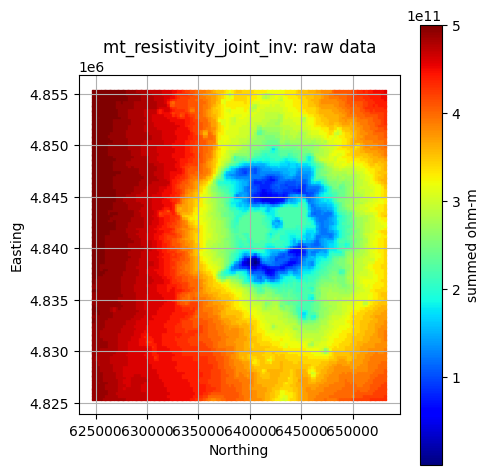

In [28]:
component = "heat"
layer = "mt_resistivity_joint_inv"

gdf = pfa["criteria"][criteria]["components"][component]["layers"][layer]["data"]
col = pfa["criteria"][criteria]["components"][component]["layers"][layer]["data_col"]
units = pfa["criteria"][criteria]["components"][component]["layers"][layer]["units"]
title = f"{layer}: raw data"

GeospatialDataPlotters.geo_plot(gdf, col, units, title, markersize=2, figsize=(5, 5))

#### Plot All Layers

Loop through the full hierarchy and visualize every raw dataset.

geologic
	heat


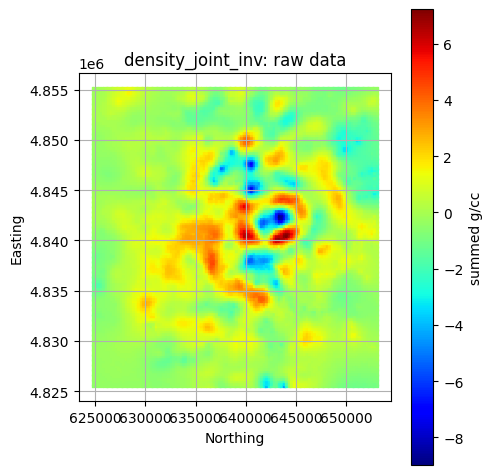

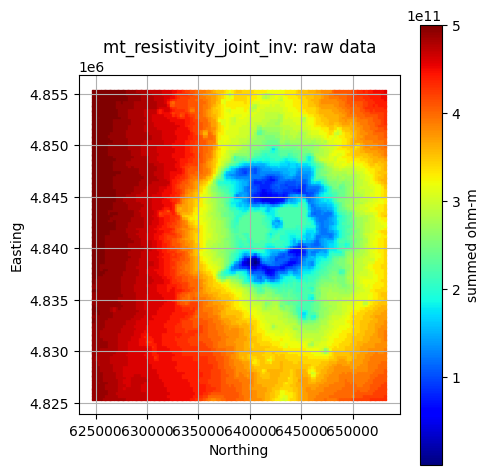

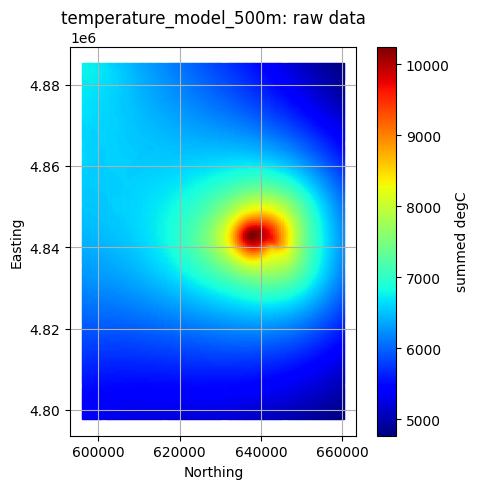

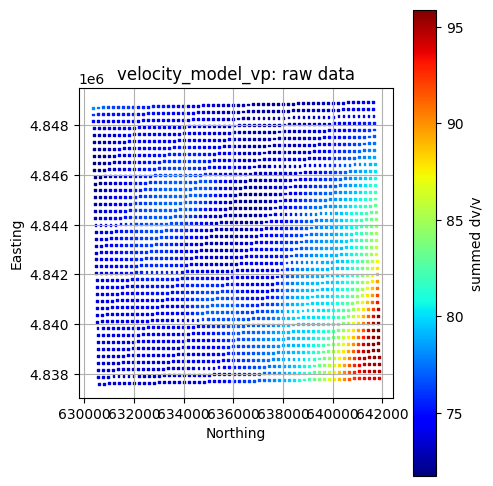

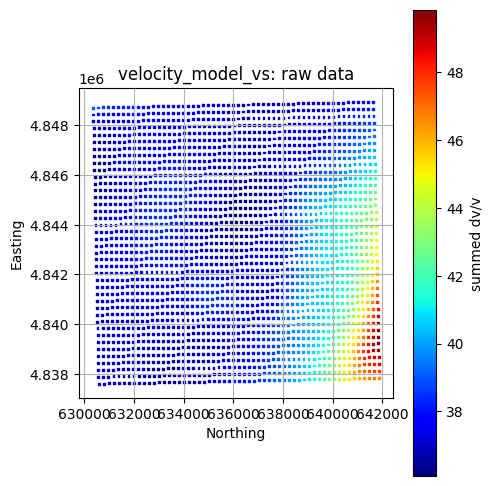

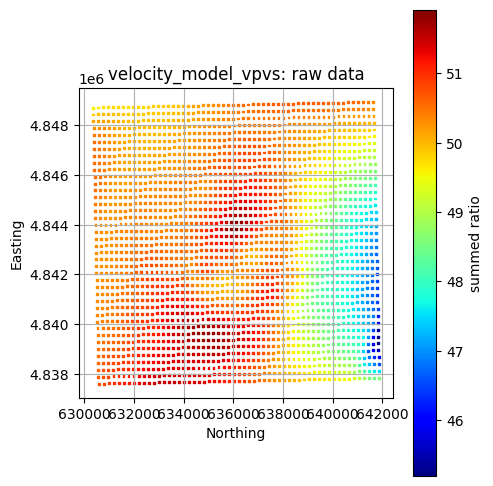

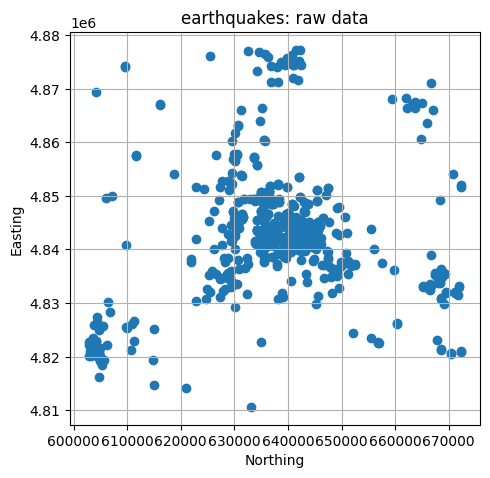

	producibility
		density_joint_inv plotted already
		mt_resistivity_joint_inv plotted already
		velocity_model_vp plotted already
		velocity_model_vs plotted already
		velocity_model_vpvs plotted already
		earthquakes plotted already


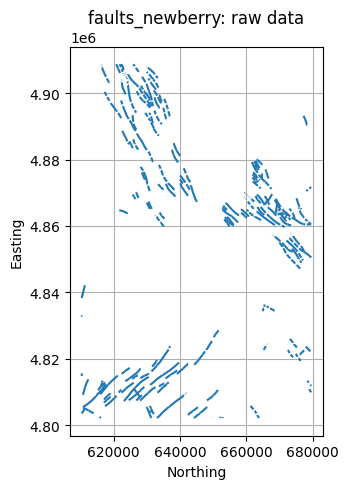

	insulation
		density_joint_inv plotted already
		mt_resistivity_joint_inv plotted already
		velocity_model_vp plotted already
		earthquakes plotted already


In [29]:
for criteria, crit_data in pfa["criteria"].items():
    print(criteria)
    plotted_layers = []
    for component, comp_data in crit_data["components"].items():
        print(f"\t{component}")
        for layer, layer_data in comp_data["layers"].items():
            if layer in plotted_layers:
                print(f"\t\t{layer} plotted already")
                continue

            gdf = layer_data["data"]
            col = layer_data.get("data_col", None)
            if layer == "faults_newberry":
                col = "None"  # faults are geometries only

            units = layer_data["units"]
            title = f"{layer}: raw data"

            GeospatialDataPlotters.geo_plot(gdf, col, units, title, markersize=2, figsize=(5, 5))
            plotted_layers.append(layer)

## 5. Data Processing and Preparation
This step transforms raw geospatial inputs into standardized layers on a shared 2D grid for comparison and combination.

Examples:
- *Permeability indicators*: distance to faults, earthquake density  
- *Heat indicators*: resistivity, temperature, low density  
- *Insulation indicators*: shallow resistivity, seismic velocity  

Processing ensures all layers:
- Are free from outliers  
- Share the same CRS and spatial extent  
- Are mapped to the same `(nx, ny)` grid  
- Represent physical meaning consistently  

---

### How It Works

All 2D `geoPFA` processing functions follow the same pattern:

1. Take the **raw input** stored in  
   `pfa["criteria"][criteria]["components"][component]["layers"][layer]["data"]`
2. Process it (e.g., interpolation, point density, distance-to-feature)  
   onto the common 2D grid
3. Write the result to  
   `pfa["criteria"][criteria]["components"][component]["layers"][layer]["model"]`

### Filter Outliers
Some datasets contain spurious extreme values.
Use Cleaners.filter_geodataframe() to remove these outliers based on a quantile threshold.

In [30]:
# Filter the upper 10% of values in selected datasets
target_layers = ["velocity_model_vs", "velocity_model_vp", "velocity_model_vpvs"]

for layer in target_layers:
    for component in ["heat", "producibility"]:
        gdf = pfa["criteria"][criteria]["components"]["heat"]["layers"][layer]["data"]
        col = pfa["criteria"][criteria]["components"]["heat"]["layers"][layer]["data_col"]

        filtered = Cleaners.filter_geodataframe(gdf, col, quantile=0.9)
        pfa["criteria"][criteria]["components"][component]["layers"][layer]["data"] = filtered

print("✅ Outlier filtering complete.")

✅ Outlier filtering complete.


C:\Users\smello\Documents\geoPFA\geoPFA\processing.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[series > q] = q
C:\Users\smello\Documents\geoPFA\geoPFA\processing.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[series > q] = q
C:\Users\smello\Documents\geoPFA\geoPFA\processing.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[series > q] = q
C:\Users\smello\Documents\geoPFA\geoPFA\pro

### Interpolation
For most datasets, data can be processed and prepared for layer combination and favorability estimation by simply interpolating data to the target grid. Here we do that only once for each input layer that has `"processing_method": "interpolate"` specified in the configuration file.

In [31]:
# Define grid resolution (number of cells in x and y)
nx = 300; ny = 300

method = 'linear'

interpolated_layers = {}

for criteria, crit_data in pfa["criteria"].items():
    print(criteria)
    for component, comp_data in crit_data["components"].items():
        print(f"\t{component}")
        for layer, layer_config in comp_data["layers"].items():
            if layer_config.get("processing_method") == "interpolate":
                if layer in interpolated_layers:
                    print(f"\t\tReusing cached interpolation for {layer}")
                    pfa["criteria"][criteria]["components"][component]["layers"][layer] = (
                        interpolated_layers[layer].copy()
                    )
                else:
                    print(f"\t\tInterpolating layer: {layer}")
                    pfa = Processing.interpolate_points(
                        pfa,
                        criteria=criteria,
                        component=component,
                        layer=layer,
                        interp_method=method,
                        nx=nx,
                        ny=ny,
                        extent=extent,
                    )
                    interpolated_layers[layer] = (
                        pfa["criteria"][criteria]["components"][component]["layers"][layer].copy()
                    )


geologic
	heat
		Interpolating layer: density_joint_inv
		Interpolating layer: mt_resistivity_joint_inv
		Interpolating layer: temperature_model_500m
		Interpolating layer: velocity_model_vp
		Interpolating layer: velocity_model_vs
		Interpolating layer: velocity_model_vpvs
	producibility
		Reusing cached interpolation for density_joint_inv
		Reusing cached interpolation for mt_resistivity_joint_inv
		Reusing cached interpolation for velocity_model_vp
		Reusing cached interpolation for velocity_model_vs
		Reusing cached interpolation for velocity_model_vpvs
	insulation
		Reusing cached interpolation for density_joint_inv
		Reusing cached interpolation for mt_resistivity_joint_inv
		Reusing cached interpolation for velocity_model_vp


### Point Density to be Used as a Favorability Proxy

For some layers, the spatial density of points (e.g., earthquake occurrences) is an indicator of permeability or fracturing.
Use Processing.point_density_3d_projected() to compute 2D density grids.

In [32]:
cell_size = 2500
pfa = Processing.point_density(pfa, criteria='geologic', component='heat', 
                               layer='earthquakes', extent=extent, cell_size=cell_size, 
                               nx=nx, ny=ny)
pfa = Processing.point_density(pfa, criteria='geologic', component='producibility', 
                               layer='earthquakes', extent=extent, cell_size=cell_size, 
                               nx=nx, ny=ny)
pfa = Processing.point_density(pfa, criteria='geologic', component='insulation', 
                               layer='earthquakes', extent=extent, cell_size=cell_size, 
                               nx=nx, ny=ny)

# Filter extreme densities
for comp in ["heat", "producibility", "insulation"]:
    gdf = pfa["criteria"]["geologic"]["components"][comp]["layers"]["earthquakes"]["model"]
    col = pfa["criteria"]["geologic"]["components"][comp]["layers"]["earthquakes"]["model_data_col"]
    filtered = Cleaners.filter_geodataframe(gdf, col, quantile=0.9)
    pfa["criteria"]["geologic"]["components"][comp]["layers"]["earthquakes"]["model"] = filtered

C:\Users\smello\Documents\geoPFA\geoPFA\processing.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[series > q] = q
C:\Users\smello\Documents\geoPFA\geoPFA\processing.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[series > q] = q
C:\Users\smello\Documents\geoPFA\geoPFA\processing.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[series > q] = q


### Process Faults

Faults often act as **pathways for fluid flow**, making them key indicators of *producibility*.  
Here, we use the built-in `process_faults()` function to calculate a **fault-based favorability score** that increases with proximity to faults and (optionally) their intersections.

The function performs:
1. **Distance calculation** – measures distance from each grid point to nearby faults.  
2. **Intersection detection** (optional) – identifies where faults intersect and computes distance to those points.  
3. **Exponential decay weighting** – applies user-defined decay constants (`alpha_fault`, `alpha_intersection`) to represent how influence decreases with distance.  
4. **Weighted combination** – combines both effects using `weight_fault` and `weight_intersection`.

> *Tuning Tip:* Larger `alpha` values spread the fault’s influence farther; smaller ones make it more localized.


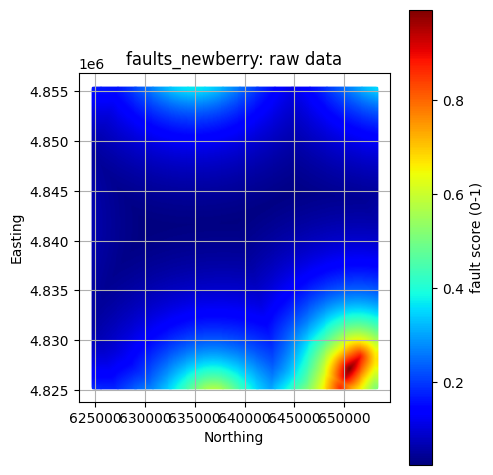

In [33]:
# --- Fault processing for producibility component ---
pfa = Processing.process_faults(
    pfa,
    criteria=criteria,
    component="producibility",
    layer="faults_newberry",
    extent=extent,
    nx=nx,
    ny=ny,
    alpha_fault=5500.0,        # decay distance for faults
    alpha_intersection=3500.0, # decay distance for intersections
    weight_fault=0.7,          # relative weighting of faults vs intersections
    weight_intersection=0.3,
    use_intersections=True,    # include intersection effects
)

#  Visualize the results
#  Note the plotted extent differs from the raw data when comparing
component = "producibility"
layer = "faults_newberry"

# Note we now grab the processed data from its "model" locations
gdf = pfa["criteria"][criteria]["components"][component]["layers"][layer]["model"]
col = pfa["criteria"][criteria]["components"][component]["layers"][layer]["model_data_col"]
units = pfa["criteria"][criteria]["components"][component]["layers"][layer]["model_units"]
title = f"{layer}: raw data"

GeospatialDataPlotters.geo_plot(gdf, col, units, title, markersize=2, figsize=(5, 5))

### Plot All Processed Layers

geologic
	heat


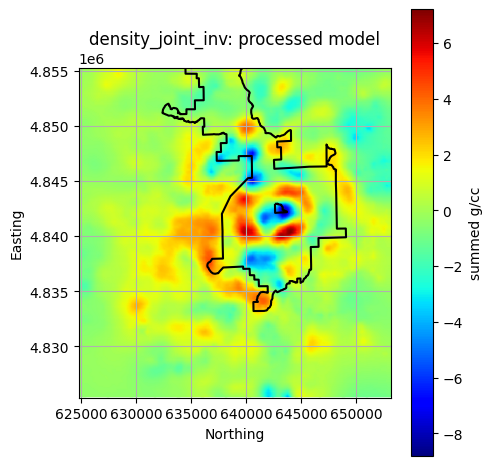

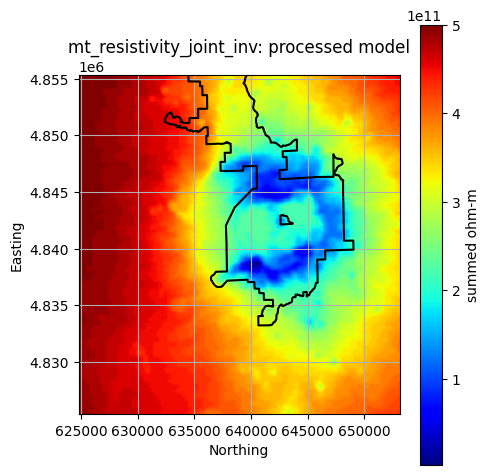

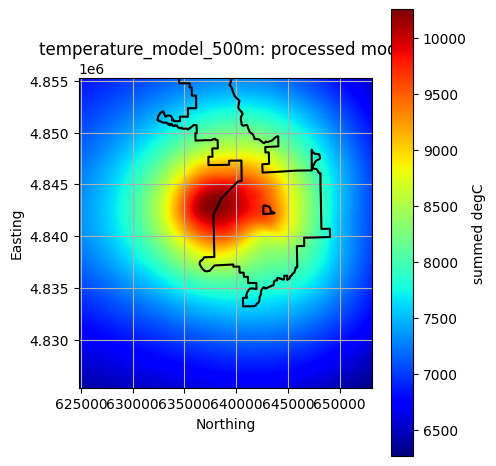

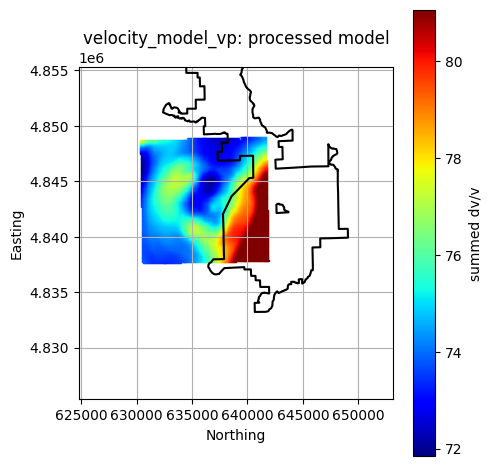

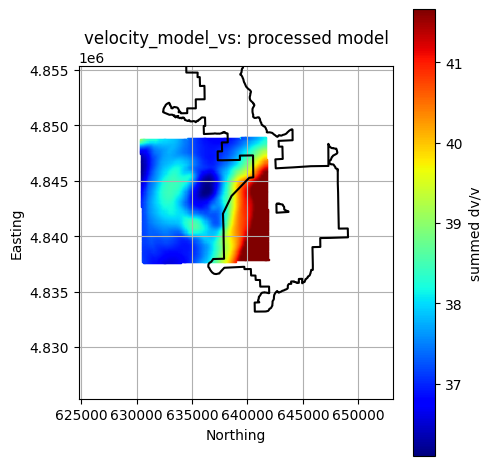

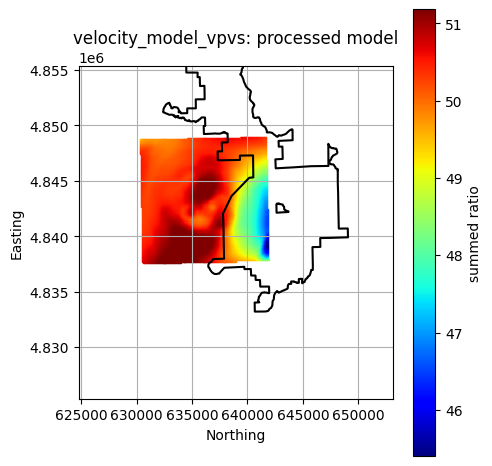

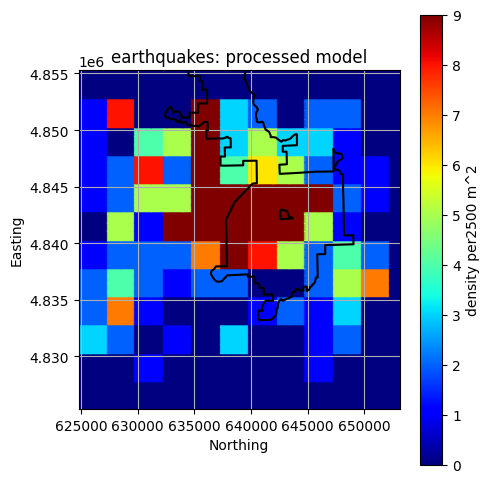

	producibility


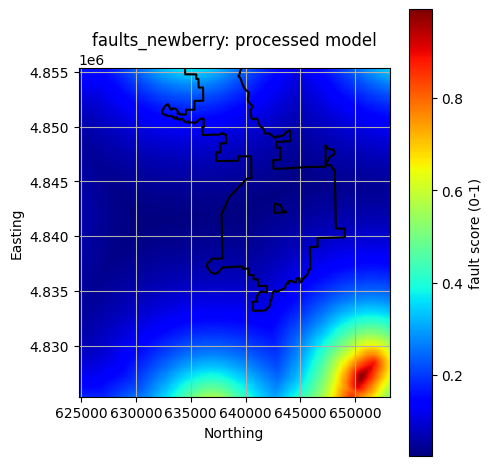

	insulation

✅ Finished plotting all available processed layers.


In [34]:
for criteria, crit_data in pfa["criteria"].items():
    print(criteria)
    plotted_layers = []

    for component, comp_data in crit_data["components"].items():
        print(f"\t{component}")

        for layer, layer_data in comp_data["layers"].items():
            if layer in plotted_layers:
                continue

            # Skip if no processed model exists
            if "model" not in layer_data or layer_data["model"] is None:
                print(f"\t\t⚠️ Skipping {layer}: no processed 'model' found.")
                continue

            gdf = layer_data["model"]
            col = layer_data.get("model_data_col")
            units = layer_data.get("model_units", "None")
            title = f"{layer}: processed model"

            # Plot in 3D
            GeospatialDataPlotters.geo_plot(
                gdf, col, units, title, area_outline=outline, extent=extent, markersize=0.75, figsize=(5, 5)
            )

            plotted_layers.append(layer)

print("\n✅ Finished plotting all available processed layers.")

## Save Processed Layers
It’s good practice to save processed data to disk before proceeding so processing only has to be completed once.

In [35]:
for criteria, crit_data in pfa["criteria"].items():
    print(criteria)
    for component, comp_data in crit_data["components"].items():
        print(f"\t{component}")
        for layer, layer_data in comp_data["layers"].items():
            gdf = layer_data["model"]
            col = layer_data["model_data_col"]
            units = layer_data["model_units"]

            out_fp = data_dir / criteria / component / f"{layer}_processed.csv"
            gdf.to_csv(out_fp, index=False)
            print(f"\t\tSaved: {out_fp}")

geologic
	heat
		Saved: c:\Users\smello\Documents\geoPFA\examples\Newberry\2D\data\geologic\heat\density_joint_inv_processed.csv
		Saved: c:\Users\smello\Documents\geoPFA\examples\Newberry\2D\data\geologic\heat\mt_resistivity_joint_inv_processed.csv
		Saved: c:\Users\smello\Documents\geoPFA\examples\Newberry\2D\data\geologic\heat\temperature_model_500m_processed.csv
		Saved: c:\Users\smello\Documents\geoPFA\examples\Newberry\2D\data\geologic\heat\velocity_model_vp_processed.csv
		Saved: c:\Users\smello\Documents\geoPFA\examples\Newberry\2D\data\geologic\heat\velocity_model_vs_processed.csv
		Saved: c:\Users\smello\Documents\geoPFA\examples\Newberry\2D\data\geologic\heat\velocity_model_vpvs_processed.csv
		Saved: c:\Users\smello\Documents\geoPFA\examples\Newberry\2D\data\geologic\heat\earthquakes_processed.csv
	producibility
		Saved: c:\Users\smello\Documents\geoPFA\examples\Newberry\2D\data\geologic\producibility\density_joint_inv_processed.csv
		Saved: c:\Users\smello\Documents\geoPFA

### Optional: Save a “Clean” PFA Config (no GeoDataFrames)
This will typically serve as the config file for the next step. We provide the file in the supplemental data as well.

In [36]:
import json

In [ ]:
def drop_geodataframes(data: dict) -> dict:
    """Recursively remove GeoDataFrame objects before saving."""
    clean = {}
    for key, val in data.items():
        if isinstance(val, gpd.GeoDataFrame):
            continue
        elif isinstance(val, dict):
            clean[key] = drop_geodataframes(val)
        else:
            clean[key] = val
    return clean

#  pfa_nodf = drop_geodataframes(pfa)
#  out_json = config_dir / "newberry_superhot_processed_config.json"
#  with open(out_json, "w") as f:
#      json.dump(pfa_nodf, f, indent=4)
#  print(f"Processed PFA configuration saved to: {out_json}")

Processed PFA configuration saved to: c:\Users\smello\Documents\geoPFA\examples\Newberry\2D\config\newberry_superhot_processed_config.json


---

## Next Steps: Layer Combination and Favorability Modeling

This concludes **Notebook 1 – Data Processing with `geoPFA`**.

In this notebook, we:
- Loaded, cleaned, and standardized all input datasets  
- Processed each layer (filtering, interpolation, density, distance, transformations)  
- Saved the resulting **processed layers** to disk

You’re now ready to combine these layers into component and criteria favorability models.

If you skip running this notebook, don’t worry — the **supplementary example data** includes all intermediate processed files.  
You can start directly with **Notebook 2 – Layer Combination and Favorability Modeling**, which loads those preprocessed layers automatically.

---
